# Sensitivity analysis for non-parametric causal estimators
Sensitivity analysis helps us study how robust an estimated effect is when the assumption of no unobserved confounding is violated. That is, how much bias does our estimate have due to omitting  an (unobserved) confounder? Known as the 
*omitted variable bias (OVB)*, it gives us a measure of how the inclusion of an omitted common cause (confounder) would have changed the estimated effect. 

This notebook shows how to estimate the OVB for general, non-parametric causal estimators. For gaining intuition, we suggest going through an introductory notebook that describes how to estimate OVB for a a linear estimator: [Sensitivity analysis for linear estimators](https://github.com/py-why/dowhy/blob/master/docs/source/example_notebooks/sensitivity_analysis_testing.ipynb). To recap, in that notebook, we saw how the OVB depended on linear partial R^2 values and used this insight to compute the adjusted estimate values depending on the relative strength of the confounder with the outcome and treatment. We now generalize the technique using the non-parametric partial R^2 and Reisz representers.


This notebook is based on Chernozhukov et al., Long Story Short: Omitted Variable Bias in Causal Machine Learning.  https://arxiv.org/abs/2112.13398. 

## I. Sensitivity analysis for partially linear models
We first analyze the sensitivity of a causal estimate when the true data-generating process (DGP) is known to be partially linear. That is, the outcome can be additively decomposed into a linear function of the treatment and a non-linear function of the confounders. 
$$ Y = g(T, W, U) + \epsilon = \theta T + h(W, U) + \epsilon $$

However, we cannot estimate the above equation because the confounders $U$ are unobserved. Thus, in practice, a causal estimator uses the following "short" equation, 
$$ Y = g_s(T, W) + \epsilon = \theta_s T + h_s(W) + \epsilon_s $$

The goal of sensitivity analysis is to answer how far $\theta_s$ would be from the true $\theta$. Chernozhukov et al. show that given a special function called Reisz function $\alpha$, the omitted variable bias, $|\theta - \theta_s|$ is bounded by $\sqrt{E[g-g_s]^2E[\alpha-\alpha_s]^2}$. For partial linear models, $\alpha$ and the "short" $\alpha_s$  are defined as, 
$$ \alpha := \frac{T - E[T | W, Z] )}{(E(T - E[T | W, Z]) ^ 2)}$$
$$ \alpha_s := \frac{(T - E[T | W] )}{(E(T - E[T | W]) ^ 2)} $$

The bound can be expressed in terms of the *partial* R^2 of the unobserved confounder $U$ with the treatment and outcome. Recall that R^2 of $U$ wrt some target $Z$ is defined as the ratio of variance of the prediction $E[Z|U]$ with the variance of $Z$, $R^2_{Z\sim U}=\frac{Var(E[Z|U])}{Var(Y)}$. We can define the partial R^2 as an extension that measures the additional gain in explanatory power conditioned on some variables $W$. 
$$ \eta^2_{Z\sim U| W} = \frac{Var(E[Z|W, U]) - Var(E[Z|W])}{Var(Z) - Var(E[Z|W])} $$

The bound is given by, 
$$ (\theta - \theta_s)^2 = E[g-g_s]^2E[\alpha-\alpha_s]^2 = S^2 C_Y^2 C_T^2 $$ 
where, 
$$ S^2 = \frac{E[(Y-g_s)^2]}{E[\alpha_s^2]}; \ \ C_Y^2 = \eta^2_{Y \sim U | T, W}, \ \ C_T^2 = \frac{\eta^2_{T\sim U | W}}{1 - \eta^2_{T\sim U | W}}$$


$S^2$ can be estimated from data. The other two parameters need to be specified manually: they convey the strength of the unobserved confounder $U$ on treatment and outcome. Below we show how to create a contour plot by specifying a range of values for $\eta^2_{Y \sim U | T, W}$ and $\eta^2_{T\sim U | W}$. We also show how to benchmark and set these values as a fraction of the maximum partial R^2 due to any subset of the observed covariates. 

### Creating a dataset with unobserved confounding 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Required libraries
import re
import numpy as np
import dowhy
from dowhy import CausalModel
import dowhy.datasets
from dowhy.utils.util import create_polynomial_function

We create a dataset with linear relationship between treatment and outcome, following the partial linear data-generating process. $\beta$ is the true causal effect.

In [3]:
np.random.seed(101) 
data = dowhy.datasets.partially_linear_dataset(beta = 10,
                                               num_common_causes = 7,
                                               num_unobserved_common_causes=1,
                                               strength_unobserved_confounding=10,
                                               num_samples = 500,
                                               num_treatments = 1,
                                               stddev_treatment_noise = 10,
                                               stddev_outcome_noise = 5
                                                )
display(data)

{'df':            W0        W1        W2        W3        W4        W5        W6  \
 0    0.345542  0.696984 -0.708658 -1.997165 -0.709139  0.165913 -0.554212   
 1   -0.075270  1.652779 -0.259591  0.282963 -0.764418  0.032002 -0.360908   
 2   -0.240272 -0.174564 -0.934469 -0.451650  1.959730  1.201015  0.471282   
 3    0.119874 -0.256127  0.318636 -0.223625  0.233940  1.549934 -0.763879   
 4    0.179436  1.410457 -0.635170 -1.263762  1.289872 -0.528325  0.122878   
 ..        ...       ...       ...       ...       ...       ...       ...   
 495 -0.918275  0.413940 -2.771209 -0.113019 -0.461614  1.309347  0.387558   
 496  0.046074  1.635913 -2.067205  0.693155 -0.102939 -0.165906  0.548974   
 497 -0.657989 -2.221034 -0.692297 -1.357233  1.977781  1.676112 -0.224756   
 498  2.065935  0.336375 -0.083284 -1.107344  1.262738  1.673617  0.822227   
 499 -0.623183  1.915742 -0.299116 -1.374898  0.494912  0.764341 -1.833552   
 
         v0          y  
 0     True   1.480448  
 1    

The true ATE for this data-generating process is,

In [4]:
data["ate"]

To simulate unobserved confounding, we remove one of the common causes from the dataset. 


In [5]:
# Observed data 
dropped_cols=["W0"]
user_data = data["df"].drop(dropped_cols, axis = 1)
# assumed graph
user_graph = data["gml_graph"]
for col in dropped_cols:
    user_graph = user_graph.replace('node[ id "{0}" label "{0}"]'.format(col), '')
    user_graph = re.sub('edge\[ source "{}" target "[vy][0]*"\]'.format(col), "", user_graph)
user_data

,W1,W2,W3,W4,W5,W6,v0,y
0,0.696984,-0.708658,-1.997165,-0.709139,0.165913,-0.554212,True,1.480448
1,1.652779,-0.259591,0.282963,-0.764418,0.032002,-0.360908,True,9.161068
2,-0.174564,-0.934469,-0.451650,1.959730,1.201015,0.471282,True,19.512323
3,-0.256127,0.318636,-0.223625,0.233940,1.549934,-0.763879,True,4.769235
4,1.410457,-0.635170,-1.263762,1.289872,-0.528325,0.122878,True,0.870015
...,...,...,...,...,...,...,...,...
495,0.413940,-2.771209,-0.113019,-0.461614,1.309347,0.387558,False,-1.485764
496,1.635913,-2.067205,0.693155,-0.102939,-0.165906,0.548974,True,17.585363
497,-2.221034,-0.692297,-1.357233,1.977781,1.676112,-0.224756,False,3.496803
498,0.336375,-0.083284,-1.107344,1.262738,1.673617,0.822227,True,6.299920


### Obtaining a causal estimate using Model, Identify, Estimate steps
Create a causal model with the "observed" data and causal graph.

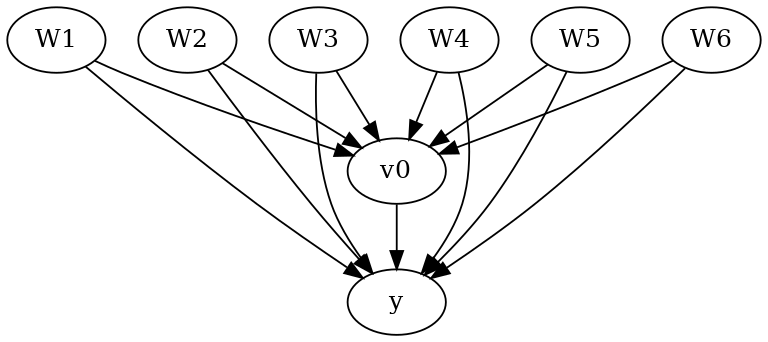

In [6]:
#graph_str = 'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"]  node[ id "W5" label "W5"] node[ id "W6" label "W6"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W5" target "v0"] edge[ source "W6" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W5" target "y"] edge[ source "W6" target "y"]]'
model = CausalModel(
            data=user_data,
            treatment=data["treatment_name"],
            outcome=data["outcome_name"],
            graph=user_graph,
            test_significance=None,
        )
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [7]:
# Identify effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W1,W6,W2,W4,W5,W3])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W6,W2,W4,W5,W3,U) = P(y|v0,W1,W6,W2,W4,W5,W3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [8]:
# Estimate effect
import econml
from sklearn.ensemble import GradientBoostingRegressor
linear_dml_estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.LinearDML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'linear_first_stages': False
                                                       },
                                        'fit_params': {'cache_values': True,}
                                     })

2022-09-04 21:38:45.602666: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-04 21:38:45.633443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-04 21:38:45.633475: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### Sensitivity Analysis using the Refute step
After estimation , we need to check how robust our estimate is against the possibility of unobserved confounders.  We perform sensitivity analysis for the LinearDML estimator assuming that its assumption on data-generating process holds: the true function for $Y$ is partial linear. 

Note that partial linear sensitivity analysis is automatically chosen if LinearDML estimator is used for estimation. For computational efficiency, you can set <b>cache_values</b> = <b>True</b> in `fit_params` to cache the results of first stage estimation. Parameters used:

* **effect_strength_on_treatment**: $\eta^2_{T\sim U | W}$, Partial R2 of unobserved confounder with treatment conditioned on all observed confounders. 
* **effect_strength_on_outcome**: $\eta^2_{Y \sim U | T, W}$, Partial R2 of unobserved confounder with outcome conditioned on treatment and all observed confounders. 

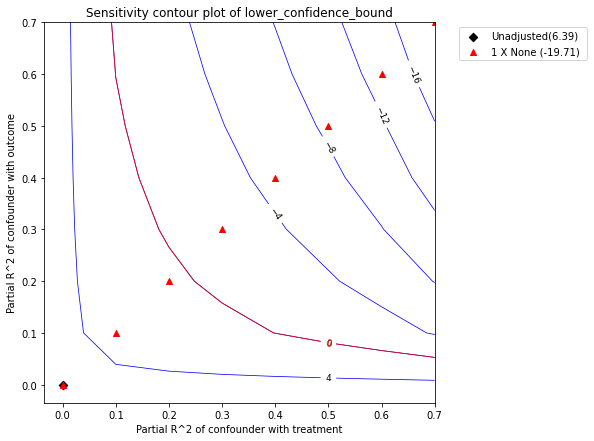

Sensitivity Analysis to Unobserved Confounding using R^2 paramterization

Original Effect Estimate : 6.388463952199702
Robustness Value : 0.29

Robustness Value (alpha=0.05) : 0.23

Interpretation of results :
Any confounder explaining less than 29.0% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 23.0% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'




In [23]:
refute = model.refute_estimate(identified_estimand, linear_dml_estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "non-parametric-partial-R2",
                               effect_strength_on_treatment = np.arange(0, 0.8, 0.1),
                               effect_strength_on_outcome = np.arange(0, 0.8, 0.1)
                              )
print(refute)

**Intepretation of the plot.** In the above plot, the x-axis shows hypothetical partial R2 values of unobserved confounder(s) with the treatment. The y-axis shows hypothetical partial R2 of unobserved confounder(s) with the outcome. At <x=0,y=0>, the black diamond shows the original estimate (theta_s) without considering the unobserved confounders.

The contour levels represent *adjusted* lower confidence bound estimate of the effect, which would be obtained if the unobserved confounder(s) had been included in the estimation model. The red contour line is the critical threshold where the adjusted effect goes to zero. Thus,  confounders with such strength or stronger are sufficient to reverse the sign of the estimated effect and invalidate the estimate's conclusions.

The red triangle shows the estimated partial-R^2 of a chosen benchmark observed covariate with the treatment and outcome. In the above call, we chose *W1* as the benchmark covariate. Under the unobserved confounder cannot be stronger in its effect on treatment and outcome than the observed benchmark covariate (*W3*), the above plot shows that the mean estimated effect will stay above 8.92 even after accounting for unobserved confounding.


In [21]:
refute_bm.RV

The robustness value measures the minimal equal strength of $\eta^2_{T\sim U | W}$ and $\eta^2_{Y \sim U | T, W}$ such the bound for the average treatment effect would include zero. <br>
A robustness value of 0.4 implies that confounders with $\eta^2_{T\sim U | W}$ and $\eta^2_{Y \sim U | T, W}$ values less than 0.4 would not be sufficient enough to bring down the estimates to zero.

**Benchmarking.** In general, however, providing a plausible range of partial R2 values is difficult. Instead,  we can infer the partial R2 of the unobserved confounder as a multiple of the partial R2 of any subset of observed confounders. So now we just need to specify the effect of unobserved confounding as a multiple/fraction of the observed confounding. This process is known as *benchmarking*.

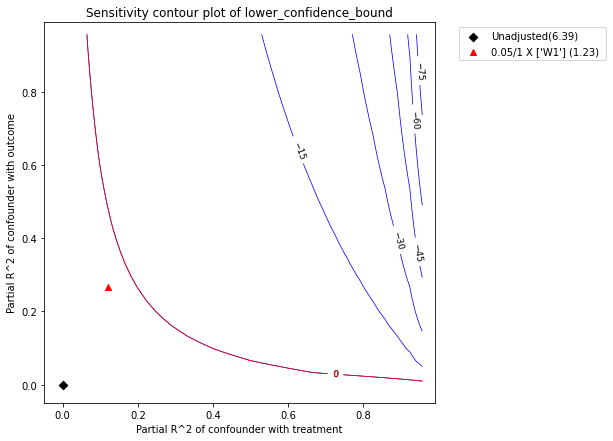

In [19]:
refute_bm = model.refute_estimate(identified_estimand, linear_dml_estimate ,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "non-parametric-partial-R2",
                               benchmark_common_causes = ["W1"],
                               effect_fraction_on_treatment = 0.05,
                               effect_fraction_on_ouctome = 0.04
                              )

The relevant arguments for the method are described below. 
- <b>benchmark_common_causes</b>: Name of the covariates used to bound the strengths of unobserved confounder<br>
- <b>effect_fraction_on_treatment</b>: Strength of association between unobserved confounder and treatment compared to benchmark covariate<br>
- <b>effect_fraction_on_outcome</b>: Strength of association between unobserved confounder and outcome compared to benchmark covariate<br>

We can also access the refutation results as a data frame.

In [20]:
refute_bm.results

,r2tu_w,r2yu_tw,short estimate,bias,lower_ate_bound,upper_ate_bound,lower_confidence_bound,upper_confidence_bound
0,0.119484,0.267973,6.388464,3.555478,2.832986,9.943942,1.231806,11.636953


## II. Sensitivity Analysis for general non-parametric models
We now perform sensitivity analysis without making any assumption on the true data-generating process. The sensitivity still depends on the partial R2 of unobserved confounder wrt. treatment and outcome, $\eta^2_{T\sim U | W}$ and $\eta^2_{Y \sim U | T, W}$ respectively, but the computation of bounds is more complicated and requires estimation of a special function known as reisz function. Refer to Chernozhukov et al. for details.

<b>identified_estimand</b>: An instance of the identifiedEstimand class that provides the information with respect to which causal pathways are employed when the treatment effects the outcome<br>
- <b>estimate</b>: An instance of CausalEstimate class. The estimate obtained from the estimator for the original data.<br>
- <b>method_name</b>: Refutation method name <br>
- <b>simulated_method_name</b>: "non-parametric-partial-R2" for Non Parametric Sensitivity Analysis<br>
- <b>num_splits</b>: number of splits for cross validation. (default = 5) <br>
- <b>shuffle_data</b> : shuffle data or not before splitting into folds (default = False)<br>
- <b>shuffle_random_seed</b>: seed for randomly shuffling data<br>
- <b>alpha_s_param_dict</b>: dictionary with parameters for finding alpha_s: <br>
    - <b>reisz_functions</b>: List of polynomial functions of n degree to approximate reisz representer created using create_polynomial_function
    - <b>l2_regularizer</b>: l2 penalty while modeling (default = 1e-3)
    - For details of other parameters other parameters of ReiszRepresenter class see: https://econml.azurewebsites.net/_autosummary/econml.grf.CausalForest.html 
- <b>g_s_estimator_list</b>: list of estimator objects for finding g_s. Example: <br> 
[<br> RandomForestRegressor(n_estimators = 100, random_state = 120),<br> 
Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), numeric_features)], remainder='passthrough')), ('lasso_model', Lasso())]),<br>
ReiszRegressor(regression_functions = create_polynomial_function(max_degree), min_var_leaf_on_val = True,min_impurity_decrease = 1e-4, max_samples = 0.80)<br>
]
- <b>g_s_estimator_param_list</b>: list of dictionaries with parameters for tuning respective estimators in g_s_estimator_list. Example: <br>
[ { 'n_estimators' : [50], 
    'max_depth' : [3, 4, 5],
    'min_samples_leaf' : [10,50]
  },<br>{'lasso_model__alpha' : [ 0.01, 0.001, 1e-4, 1e-5, 1e-6]},<br>
  {'regression_functions' : [create_polynomial_function(2), create_polynomial_function(4)],
   'min_samples_leaf' : [10, 50],
   'min_var_fraction_leaf' : [0.01, 0.1],
   'l2_regularizer' : [1e-2, 1e-3]
   }<br>
]
    - The parameters for ReiszRegressor
        - <b>regression_functions</b>: List of polynomial functions of n degree to approximate reisz regressor created using create_polynomial_function
        - <b>l2_regularizer</b>: l2 penalty while modeling (default = 1e-3)
        - For details of other parameters of ReiszRegressor class see: https://econml.azurewebsites.net/_autosummary/econml.grf.CausalForest.html 
- <b>benchmark_common_causes</b>: Name of the covariates used to bound the strengths of unobserved confounder<br>
- <b>effect_fraction_on_treatment</b>: Strength of association between unobserved confounder and treatment compared to benchmark covariate<br>
- <b>effect_fraction_on_outcome</b>: Strength of association between unobserved confounder and outcome compared to benchmark covariate<br>
- <b>plot_estimate</b>: Generate contour plot for estimate while performing sensitivity analysis. (default = True). To override the setting, set plot_estimate = False.

In [25]:
# Estimate effect using a non-parametric estimator
import econml
from sklearn.ensemble import GradientBoostingRegressor
estimate_npar = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.KernelDML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),                                                       },
                                        'fit_params': {},#{'cache_values': True,}
                                     })
print(estimate_npar)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                          
─────(E[y|W1,W6,W2,W4,W5,W3])
d[v₀]                        
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W6,W2,W4,W5,W3,U) = P(y|v0,W1,W6,W2,W4,W5,W3)

## Realized estimand
b: y~v0+W1+W6+W2+W4+W5+W3 | 
Target units: ate

## Estimate
Mean value: 6.4248443816734655
Effect estimates: [6.42484438 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438
 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438
 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438
 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438
 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438
 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438
 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438 6.42484438
 6.42484438 6.42484438 6.42484438 6.42484438 6

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


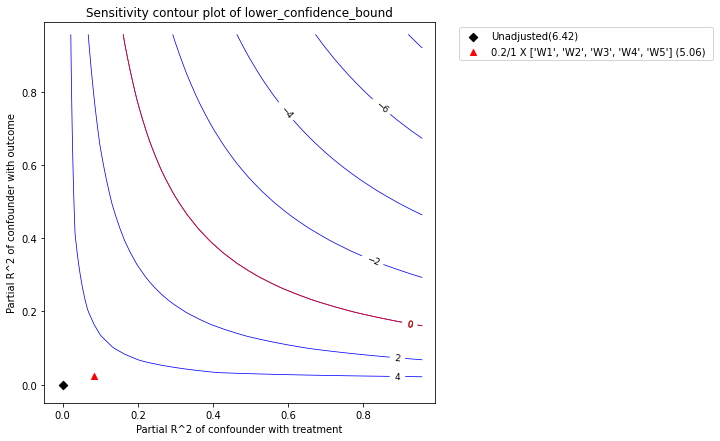

Sensitivity Analysis to Unobserved Confounding using R^2 paramterization

Original Effect Estimate : 6.4248443816734655
Robustness Value : 0.45

Robustness Value (alpha=0.05) : 0.4

Interpretation of results :
Any confounder explaining less than 45.0% percent of the residual variance of both the treatment and the outcome would not be strong enough to explain away the observed effect i.e bring down the estimate to 0 

For a significance level of 5.0%, any confounder explaining more than 40.0% percent of the residual variance of both the treatment and the outcome would be strong enough to make the estimated effect not 'statistically significant'




In [27]:
refute_npar = model.refute_estimate(identified_estimand, estimate_npar,
                               method_name = "add_unobserved_common_cause",
                               simulated_method_name = "non-parametric-partial-R2",
                               alpha_s_estimator_param_list =  None,
                               benchmark_common_causes = ["W1", "W2", "W3", "W4", "W5"],
                               effect_fraction_on_treatment = 0.2,
                               plugin_reisz=True
                              )
print(refute_npar)


The x-axis shows (hypothetical) partial R^2 values of unobserved confounder(s) with the treatment. The y-axis shows hypothetical partial R^2 of unobserved confounder(s) with the outcome. At <x=0,y=0>, the black diamond shows the original estimate (theta_s) without considering the unobserved confounders.

The contour levels represent *adjusted* lower confidence bound estimate of the effect, which would be obtained if the unobserved confounder(s) had been included in the estimation model. The red contour line is the critical threshold where the adjusted effect goes to zero. Thus,  confounders with such strength or stronger are sufficient to reverse the sign of the estimated effect and invalidate the research conclusions.

The red triangle shows the estimated partial-R^2 of a chosen benchmark observed covariate with the treatment and outcome. In the above call, we chose *W3* as the benchmark covariate which has very low partial-R^2. Under the unobserved confounder cannot be stronger in its effect on treatment and outcome than the observed benchmark covariate (*W3*), the above plot shows that the mean estimated effect will stay above 8.92 even after accounting for unobserved confounding.

To verify, the true causal effect can be seen below. 

In [ ]:
refute.S2

##### Parameter List for plot function
- <b>plot_type</b>: possible values are 'bias','lower_ate_bound','upper_ate_bound','lower_confidence_bound','upper_confidence_bound'<br>
- <b>x_limit</b>: plot's maximum x_axis value (default = 0.8) <br>
- <b>y_limit</b>: plot's minimum y_axis value (default = 0.8) <br>
- <b>num_points_per_contour</b>: number of points to calculate and plot each contour line (default = 200) <br>
- <b>plot_size</b>: tuple denoting the size of the plot (default = (7,7))<br>
- <b>contours_color</b>: color of contour line (default = blue)<br>
String or array. If array, lines will be plotted with the specific color in ascending order.<br>
- <b>critical_contour_color</b>: color of threshold line (default = red)<br>
- <b>label_fontsize</b>: fontsize for labelling contours (default = 9)<br>
- <b>contour_linewidths</b>: linewidths for contours (default = 0.75)<br>
- <b>contour_linestyles</b>: linestyles for contours (default = "solid") See : https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/linestyles.html<br>
- <b>contours_label_color</b>: color of contour line label (default = black)<br>
- <b>critical_label_color</b>: color of threshold line label (default = red)<br>
- <b>unadjusted_estimate_marker</b>: marker type for unadjusted estimate in the plot (default = 'D')
See: https://matplotlib.org/stable/api/markers_api.html <br>
- <b>unadjusted_estimate_color</b>: marker color for unadjusted estimate in the plot (default = "black")<br>
- <b>adjusted_estimate_marker</b>: marker type for bias adjusted estimates in the plot (default = '^')<br>
- <b>adjusted_estimate_color</b>: marker color for bias adjusted estimates in the plot (default = "red")<br>
- <b>legend_position</b>:tuple denoting the position of the legend (default = (1.6, 0.6))<br>

In [ ]:
refute.plot(plot_type = "upper_ate_bound")

In [ ]:
refute.plot(plot_type = "bias")

In [ ]:
refute.results

In [ ]:
print(refute)

The robustness value measures the minimal equal strength of r2yu_tw and r2tu_w such the bound for the average treatment effect would include zero. It can be between 0 and 1.<br>
A low robustness value implies that the results can be changed even by the presence of weak confounders whereas a robustness value close to 1 means the treatment effect can handle strong confounders explaining  almost all residual variation of the treatment and the outcome.
A robustness value of 0.68 implies that confounders with r2yu_tw and r2tu_w values less than 0.68 would not be sufficient enough to bring down the estimates to zero.